In this homework we will construct and analyze a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2024

We will achive this in 2 steps.

Step 1 : Construct the Dataset - Data Acquisition

Step 2: Data Analysis

# Step 1: Data Acquisition

We will first import the required python libraries. And load the CSV file containing the list of rare disease articles. The CSV file is stored in our data folder and we will be using Pandas to read and store our CSV.

In [4]:
#Import required libraries
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Plotting
import json # Hanldle JSON
import time # Time based operations
import urllib.parse # URL encoding
import requests # Request to APIs

In [5]:
#Import the csv with the list of articles
df = pd.read_csv('data/rare-disease_cleaned.AUG.2024.csv')

In [6]:
# To view the first 5 rows of the table
df.head()

,disease,pageid,url
0,Klinefelter syndrome,19833554,https://en.wikipedia.org/wiki/Klinefelter_synd...
1,Aarskog–Scott syndrome,7966521,https://en.wikipedia.org/wiki/Aarskog–Scott_sy...
2,Abetalipoproteinemia,68451,https://en.wikipedia.org/wiki/Abetalipoprotein...
3,MT-TP,20945466,https://en.wikipedia.org/wiki/MT-TP
4,Ablepharon macrostomia syndrome,10776100,https://en.wikipedia.org/wiki/Ablepharon_macro...


In [7]:
#Making a list of all the article titles
articles = [f'{name}' for name in df['disease']]

In [8]:
print(articles)

['Klinefelter syndrome', 'Aarskog–Scott syndrome', 'Abetalipoproteinemia', 'MT-TP', 'Ablepharon macrostomia syndrome', 'Acanthocheilonemiasis', 'Acanthosis nigricans', 'Aceruloplasminemia', 'Megaesophagus', 'Achard–Thiers syndrome', 'Achondrogenesis', 'Achondroplasia', 'Dwarfism', 'Osteochondrodysplasia', 'Fibroblast growth factor receptor 3', 'Vestibular schwannoma', 'Brain tumor', 'Acquired generalized lipodystrophy', 'Barraquer–Simons syndrome', 'Acrodermatitis enteropathica', 'Zinc deficiency', 'Brown-Séquard syndrome', 'Spinal cord injury', 'Brucellosis', 'Yellowstone Park bison herd', 'Māui dolphin', 'Brugada syndrome', 'Nav1.8', 'Sports cardiology', 'Budd–Chiari syndrome', 'Thrombosis', 'Hepatic veno-occlusive disease', 'Thromboangiitis obliterans', 'Bullous pemphigoid', 'Pemphigoid', 'Trigonocephaly', 'CADASIL', 'Campomelic dysplasia', 'Camurati–Engelmann disease', 'Canavan disease', 'Spongy degeneration of the central nervous system', 'Candidiasis', 'Breastfeeding difficulties

In [9]:
#Sorting the articles
articles.sort()

## Making API calls

After we’ve collected the data, we’ll process it by bringing together views from different access types like desktop, mobile web, and mobile apps. We’ll also create a cumulative dataset that covers all pageviews. This processed data will be saved in JSON files, which we’ll use for visualizations in the next step.


In [10]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.010       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<diagra@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.

# Setting up the start and the end date - July 2015 and October 2024 respectively
start_date = "2015070100"
end_date = "2024100100"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this we will change for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       start_date,
    "end":         end_date
}


In [11]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS, access_type = None):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    # Setting the Access Type in the request template
    request_template['access'] = access_type


    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [37]:
def process_articles():
  desktop_views = []
  mobile_views = []
  all_access_views = []
  for idx, article in enumerate(articles):
    print(f"Article : {idx+1}/{len(articles)}: {article}")

    mobile_app_data = request_pageviews_per_article(article, access_type = 'mobile-app')
    mobile_web_data = request_pageviews_per_article(article, access_type = 'mobile-web')
    if 'items' in mobile_web_data and 'items' in mobile_app_data and mobile_web_data['items'] and mobile_app_data['items']:
      for web_record, app_record in zip(mobile_web_data['items'], mobile_app_data['items']):
          if web_record['timestamp'] == app_record['timestamp']:
              mobile_views.append({
                  "article_title": article,
                  "timestamp": web_record['timestamp'],
                  "views": web_record['views'] + app_record['views']
              })
    else:
        print(f"No 'items' found for article: {article}")
    desktop_data = request_pageviews_per_article(article, access_type = 'desktop')
    # Check if 'items' exist in the response before proceeding
    if 'items' in desktop_data and desktop_data['items']:
        for record in desktop_data['items']:
          # For each month, we want the article title, timestamp, and number of views
          desktop_views.append({
              "article_title": article,
              "timestamp": record['timestamp'],
              "views": record['views']
          })
    else:
        print(f"No 'items' found for article: {article}")

    if 'items' in desktop_data and desktop_data['items'] and 'items' in mobile_web_data and 'items' in mobile_app_data and mobile_web_data['items'] and mobile_app_data['items']:
      for web_record, app_record in zip(mobile_web_data['items'], mobile_app_data['items']):
        if web_record['timestamp'] == app_record['timestamp']:
          matching_desktop_record = next((rec for rec in desktop_data['items'] if rec['timestamp'] == web_record['timestamp']), None)
          if matching_desktop_record:
            all_access_views.append({
                "article_title": article,
                "timestamp": web_record['timestamp'],
                "views": matching_desktop_record['views'] + web_record['views'] + app_record['views']
            })

  return desktop_views, mobile_views, all_access_views

def save_file(access_type, views):

  # Once all the data is collected, we convert it to Data Frame files
  df_view = pd.DataFrame(views)
  filename = 'data/rare-disease_monthly_' + access_type + '_' + start_date + '-' + end_date + '.json'
  # And then save it as JSON Files
  df_view.to_json(filename, orient='records')

In [32]:
#Initialize a dictionary for storing respecitve views
desktop_views = []
mobile_app_views = []
mobile_web_views = []

In [38]:
# FOR DESKTOP
desktop_views, mobile_views, all_types_views = process_articles()
save_file('desktop', desktop_views)

# FOR MOBILE
save_file('mobile', mobile_views)


# FOR ALL TYPES
save_file('all-types', all_types_views)


Article : 1/1773: 18p
Article : 2/1773: 18p-
Article : 3/1773: 2006 in Africa
Article : 4/1773: 2007 in Africa
Article : 5/1773: 2009 swine flu pandemic vaccine
Article : 6/1773: 21-Hydroxylase
Article : 7/1773: 22q13 deletion syndrome
Article : 8/1773: 3-M syndrome
Article : 9/1773: 3-Methylglutaconic aciduria
Article : 10/1773: AA amyloidosis
Article : 11/1773: ABCA1
Article : 12/1773: ADAR
Article : 13/1773: AGGF1
Article : 14/1773: AIDS dysmorphic syndrome
Article : 15/1773: AIDS-related lymphoma
Article : 16/1773: AL amyloidosis
Article : 17/1773: ATR-16 syndrome
Article : 18/1773: ATR-X syndrome
Article : 19/1773: Aarskog–Scott syndrome
Article : 20/1773: Abdominal migraine
Article : 21/1773: Abetalipoproteinemia
Article : 22/1773: Ablepharon macrostomia syndrome
Article : 23/1773: Acanthocheilonemiasis
Article : 24/1773: Acanthosis nigricans
Article : 25/1773: Aceruloplasminemia
Article : 26/1773: Acetylcholine
Article : 27/1773: Achard–Thiers syndrome
Article : 28/1773: Achondr

# Step 2 : Data Analysis

We’ll create visualizations to highlight trends in pageviews over time. This will involve:

- Identifying articles with the highest and lowest average views
- Highlighting the top 10 articles with peak pageviews
- Finding articles that have the fewest months of data

Each graph will be saved in the images folder.


Here first we will load the data for both Desktop and Mobile. We will use the library JSON to load the josn files and then use Pandas to convert them to DataFrames.

In my usecase I was having issues with the default format of timestamp conversion so I defined a format which worked for my use case.

In [19]:
# Convert timestamp column to datetime
def fix_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d00')
    return df

# Load data
with open('/data/rare-disease_monthly_desktop_2015070100-2024100100.json') as f:
    desktop_json = json.load(f)
with open('/data/rare-disease_monthly_mobile_2015070100-2024100100.json') as f:
    mobile_json = json.load(f)

# Convert to DataFrame
df_desktop = pd.DataFrame(desktop_json)
df_mobile = pd.DataFrame(mobile_json)

# Fix timestamps
df_desktop = fix_timestamp(df_desktop)
df_mobile = fix_timestamp(df_mobile)


Now we will
Max and Min Average Page Views

For this first graph, we’re looking at the articles with the highest and lowest average page views. We’ll plot both desktop and mobile access for these articles.

The goal is to see which articles are getting the most and least attention across the entire time range.
"""

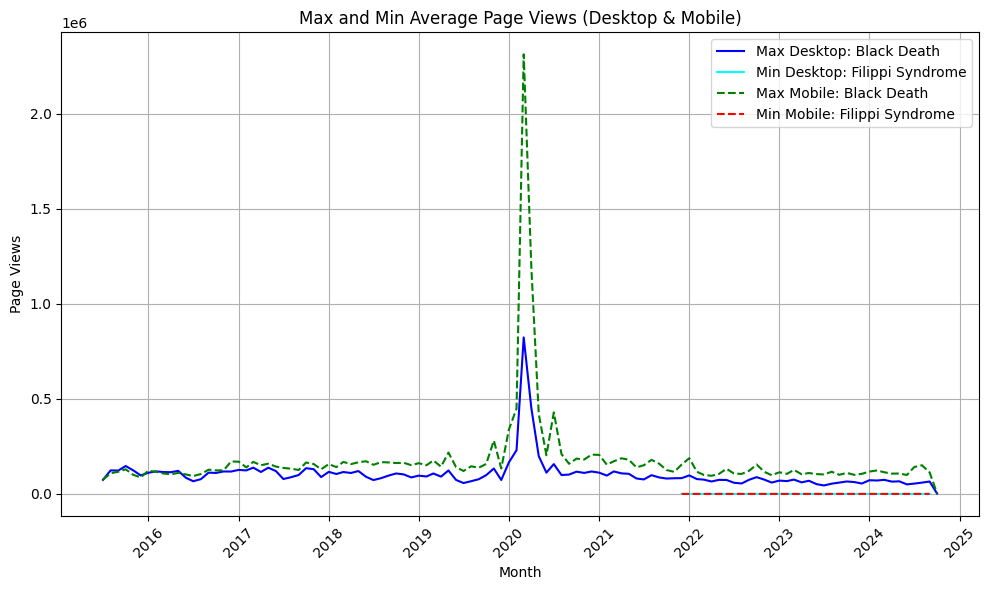

In [20]:
# Calculate average views per article
def calc_avg_views(df):
    """Get the average views for each article."""
    return df.groupby('article_title')['views'].mean()

# Get max and min average views
def find_max_min_articles(avg_views):
    """Find articles with the max and min average views."""
    return avg_views.idxmax(), avg_views.idxmin()

# Filter data for a specific article
def filter_article_data(df, article):
    return df[df['article_title'] == article]

# Plot max and min articles' views
def plot_max_min(df_max_desktop, df_min_desktop, df_max_mobile, df_min_mobile, max_desktop_article, min_desktop_article, max_mobile_article, min_mobile_article):
    """Plot the views for max and min viewed articles."""
    plt.figure(figsize=(10, 6))

    # Plot for desktop max and min
    plt.plot(df_max_desktop['timestamp'], df_max_desktop['views'], label=f'Max Desktop: {max_desktop_article}', linestyle='-', color='blue')
    plt.plot(df_min_desktop['timestamp'], df_min_desktop['views'], label=f'Min Desktop: {min_desktop_article}', linestyle='-', color='cyan')

    # Plot for mobile max and min
    plt.plot(df_max_mobile['timestamp'], df_max_mobile['views'], label=f'Max Mobile: {max_mobile_article}', linestyle='--', color='green')
    plt.plot(df_min_mobile['timestamp'], df_min_mobile['views'], label=f'Min Mobile: {min_mobile_article}', linestyle='--', color='red')

    plt.title('Max and Min Average Page Views (Desktop & Mobile)')
    plt.xlabel('Month')
    plt.ylabel('Page Views')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/plots/max_min_average_views.png')
    plt.show()

# Calculate average views per article
desktop_avg = calc_avg_views(df_desktop)
mobile_avg = calc_avg_views(df_mobile)

# Find max and min articles by average views
max_desktop_article, min_desktop_article = find_max_min_articles(desktop_avg)
max_mobile_article, min_mobile_article = find_max_min_articles(mobile_avg)

# Get data for max and min articles
df_max_desktop = filter_article_data(df_desktop, max_desktop_article)
df_min_desktop = filter_article_data(df_desktop, min_desktop_article)
df_max_mobile = filter_article_data(df_mobile, max_mobile_article)
df_min_mobile = filter_article_data(df_mobile, min_mobile_article)

# Plot max and min average page views
plot_max_min(df_max_desktop, df_min_desktop, df_max_mobile, df_min_mobile, max_desktop_article, min_desktop_article, max_mobile_article, min_mobile_article)



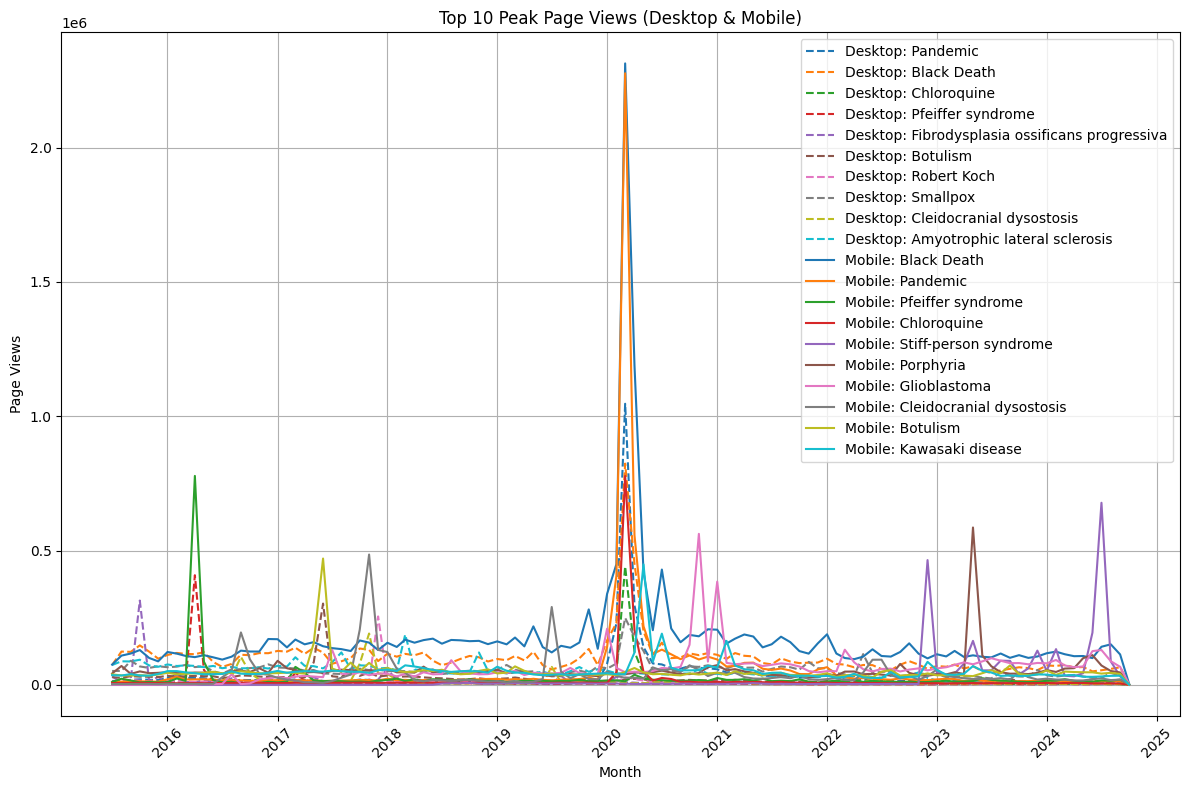

In [24]:
# Plot top 10 peak views for desktop and mobile
def plot_top_peak_views(df_desktop, df_mobile, desktop_peak, mobile_peak):
    plt.figure(figsize=(12, 8))

    # Desktop data (dashed)
    for article in desktop_peak.index:
        data = df_desktop[df_desktop['article_title'] == article]
        plt.plot(data['timestamp'], data['views'], label=f'Desktop: {article}', linestyle='--')

    # Mobile data (solid)
    for article in mobile_peak.index:
        data = df_mobile[df_mobile['article_title'] == article]
        plt.plot(data['timestamp'], data['views'], label=f'Mobile: {article}', linestyle='-')

    plt.title('Top 10 Peak Page Views (Desktop & Mobile)')
    plt.xlabel('Month')
    plt.ylabel('Page Views')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/plots/top_peaks_views.png')
    plt.show()

# Find top 10 articles with the largest peak views
desktop_peak = df_desktop.groupby('article_title')['views'].max().nlargest(10)
mobile_peak = df_mobile.groupby('article_title')['views'].max().nlargest(10)

# Plot top 10 peak views for desktop and mobile
plot_top_peak_views(df_desktop, df_mobile, desktop_peak, mobile_peak)


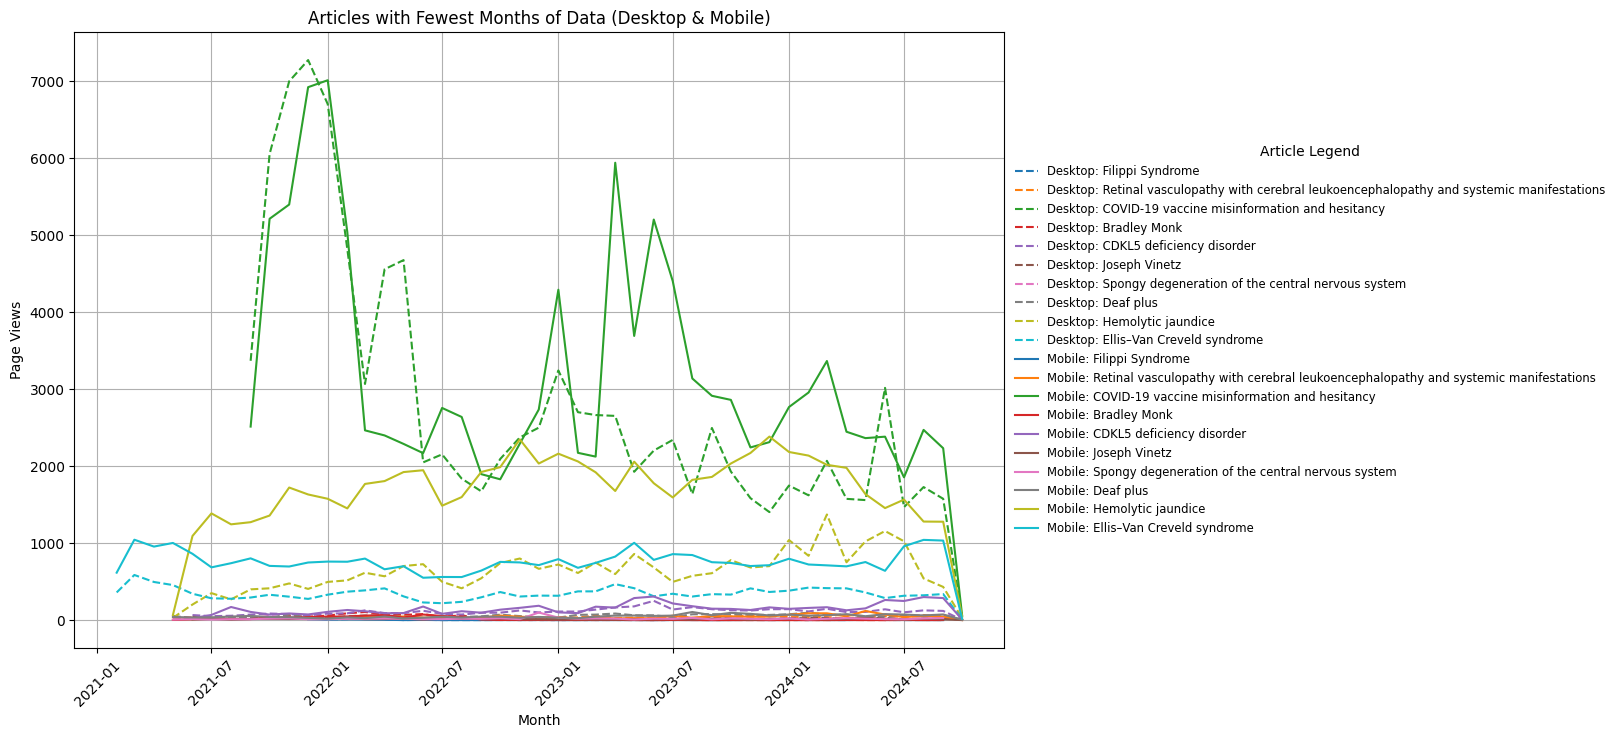

In [48]:

# Plot articles with the fewest months of data
def plot_fewest_months(df_desktop, df_mobile, desktop_fewest, mobile_fewest):
    plt.figure(figsize=(12, 8))

    # Desktop (dashed lines)
    for article in desktop_fewest.index:
        data = df_desktop[df_desktop['article_title'] == article]
        plt.plot(data['timestamp'], data['views'], label=f'Desktop: {article}', linestyle='--')

    # Mobile (solid lines)
    for article in mobile_fewest.index:
        data = df_mobile[df_mobile['article_title'] == article]
        plt.plot(data['timestamp'], data['views'], label=f'Mobile: {article}', linestyle='-')

    plt.title('Articles with Fewest Months of Data (Desktop & Mobile)')
    plt.xlabel('Month')
    plt.ylabel('Page Views')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Article Legend", frameon=False, fontsize='small')
    plt.savefig('/plots/fewest_month_views.png')
    plt.show()



# Find articles with fewest months of data
desktop_fewest_months = df_desktop.groupby('article_title')['timestamp'].count().nsmallest(10)
mobile_fewest_months = df_mobile.groupby('article_title')['timestamp'].count().nsmallest(10)

# Plot fewest months of data for desktop and mobile
plot_fewest_months(df_desktop, df_mobile, desktop_fewest_months, mobile_fewest_months)
